In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import numpy as np
import time

from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report, confusion_matrix
from sklearn.ensemble import IsolationForest, RandomForestClassifier

In [2]:
import warnings
warnings.filterwarnings("ignore")
well_13 = pd.read_excel('VolveData_Project.xlsx', sheet_name='well 13',index_col=0)
well_14 = pd.read_excel('VolveData_Project.xlsx', sheet_name='well 14')
well_15 = pd.read_excel('VolveData_Project.xlsx', sheet_name='well 15')
data = pd.concat([well_14,well_15],axis=0)

In [3]:
data["Well"] = data["Well"].astype('category')
data['RT_log'] = np.log(data['RT'])
data

,Depth,Well,GR,RT,RHOB,NPHI,Facies,RT_log
0,3178.5,14,50.2190,0.5888,2.3296,0.3657,SH,-0.529669
1,3179.0,14,47.2468,0.7768,2.3170,0.3776,UN,-0.252572
2,3179.5,14,49.5247,1.0707,2.2960,0.5390,SH,0.068313
3,3180.0,14,44.9124,1.4460,2.2514,0.5482,UN,0.368801
4,3180.5,14,47.0048,0.9542,2.2733,0.5076,UN,-0.046882
...,...,...,...,...,...,...,...,...
1154,4083.5,15,59.7060,1.7590,2.4851,0.1416,CB,0.564745
1155,4084.0,15,58.4170,1.6510,2.4860,0.1416,CB,0.501381
1156,4084.5,15,57.4990,1.5970,2.5311,0.1527,CB,0.468127
1157,4085.0,15,56.7850,1.4820,2.4731,0.1785,CB,0.393393


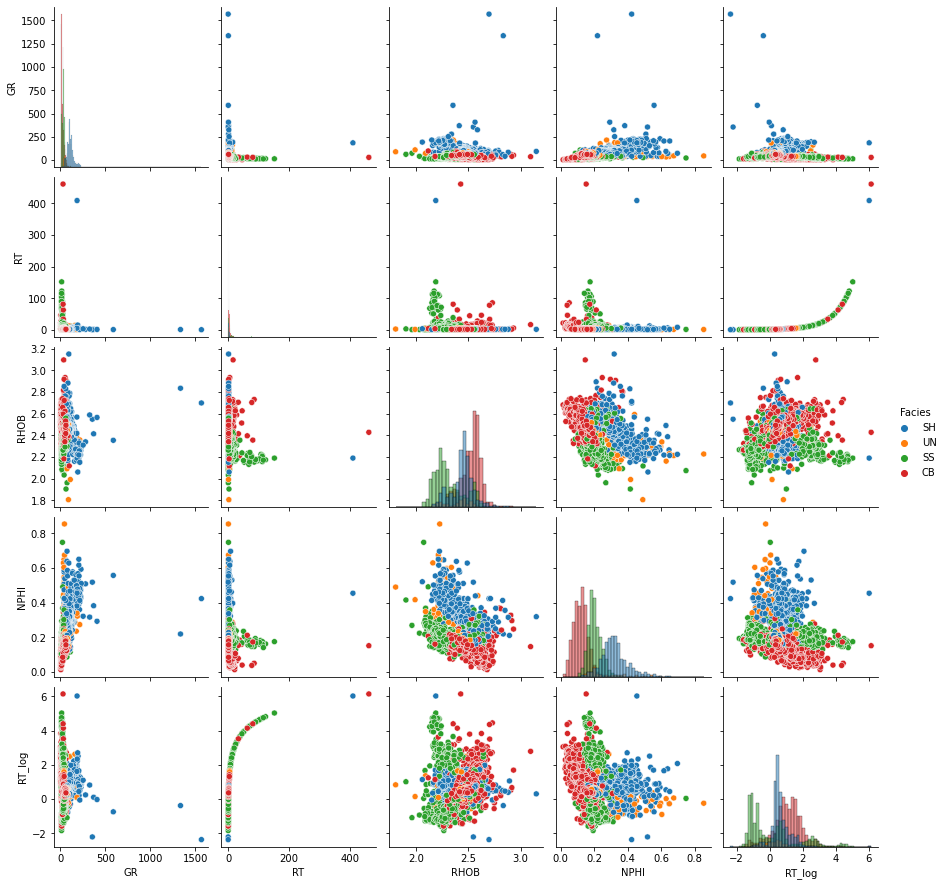

In [4]:
sns.pairplot(data.drop(['Depth','Well'],axis=1), hue="Facies",diag_kind = "hist")

In [5]:
labels = [1,2,3,4]
data['Facies_Label']= np.select([data['Facies'] == 'SH',
                                 data['Facies'] == 'UN',
                                 data['Facies'] == 'SS',
                                 data['Facies'] == 'CB',]
                                ,labels)

In [6]:
data

,Depth,Well,GR,RT,RHOB,NPHI,Facies,RT_log,Facies_Label
0,3178.5,14,50.2190,0.5888,2.3296,0.3657,SH,-0.529669,1
1,3179.0,14,47.2468,0.7768,2.3170,0.3776,UN,-0.252572,2
2,3179.5,14,49.5247,1.0707,2.2960,0.5390,SH,0.068313,1
3,3180.0,14,44.9124,1.4460,2.2514,0.5482,UN,0.368801,2
4,3180.5,14,47.0048,0.9542,2.2733,0.5076,UN,-0.046882,2
...,...,...,...,...,...,...,...,...,...
1154,4083.5,15,59.7060,1.7590,2.4851,0.1416,CB,0.564745,4
1155,4084.0,15,58.4170,1.6510,2.4860,0.1416,CB,0.501381,4
1156,4084.5,15,57.4990,1.5970,2.5311,0.1527,CB,0.468127,4
1157,4085.0,15,56.7850,1.4820,2.4731,0.1785,CB,0.393393,4


In [7]:
facies_colors = ['#2E86C1', '#196F3D','#F4D03F','#DC7633']

facies = ['SH', 'UN', 'SS', 'CB']

def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies_Label'].values,1), 100,1)
    
    fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.RT_log, logs.Depth, '-')
    ax[2].plot(logs.NPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.RHOB, logs.Depth, '-', color='r')
    im=ax[4].imshow(cluster, interpolation='none', aspect='auto',
                   cmap=cmap_facies,vmin=1,vmax=4)
    
    divider = make_axes_locatable(ax[4])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((50*' ').join(['SH', 'UN', 'SS', 'CB']))
    cbar.set_ticks(range(0,100)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("RT")
    ax[1].set_xlim(logs.RT_log.min(),logs.RT_log.max())
    ax[2].set_xlabel("NPHI")
    ax[2].set_xlim(logs.NPHI.min(),logs.NPHI.max())
    ax[3].set_xlabel("RHOB")
    ax[3].set_xlim(logs.RHOB.min(),logs.RHOB.max())
    ax[4].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([]); ax[4].set_yticklabels([])
    ax[4].set_xticklabels([])
    fig.suptitle('Well: %s'%logs.iloc[20]['Well'], fontsize=14,y=0.94)

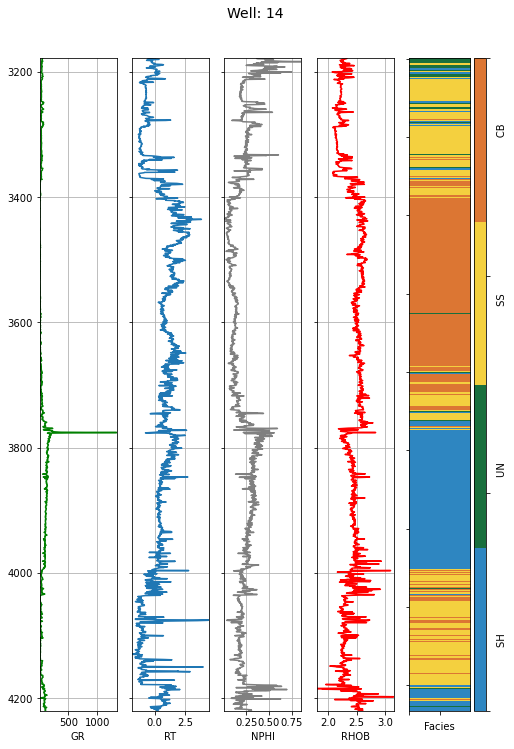

In [8]:
make_facies_log_plot(data[data['Well'] == 14],facies_colors)

<AxesSubplot:title={'center':'Distribution of Facies'}>

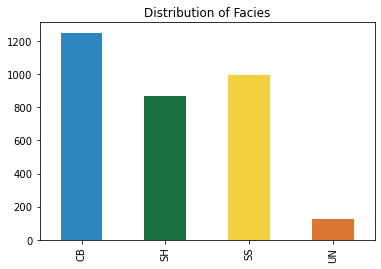

In [9]:
Facies_dist = data['Facies'].value_counts().sort_index()

Facies_dist.plot(kind='bar',color=facies_colors, 
                   title='Distribution of Facies')

In [10]:
data.set_index('Depth',inplace=True)


data.groupby("Well").count()

data.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 3241 entries, 3178.5 to 4085.5
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Well          3241 non-null   category
 1   GR            3241 non-null   float64 
 2   RT            3241 non-null   float64 
 3   RHOB          3241 non-null   float64 
 4   NPHI          3241 non-null   float64 
 5   Facies        3241 non-null   object  
 6   RT_log        3241 non-null   float64 
 7   Facies_Label  3241 non-null   int32   
dtypes: category(1), float64(5), int32(1), object(1)
memory usage: 193.2+ KB


In [11]:
data

,Well,GR,RT,RHOB,NPHI,Facies,RT_log,Facies_Label
Depth,,,,,,,,
3178.5,14,50.2190,0.5888,2.3296,0.3657,SH,-0.529669,1
3179.0,14,47.2468,0.7768,2.3170,0.3776,UN,-0.252572,2
3179.5,14,49.5247,1.0707,2.2960,0.5390,SH,0.068313,1
3180.0,14,44.9124,1.4460,2.2514,0.5482,UN,0.368801,2
3180.5,14,47.0048,0.9542,2.2733,0.5076,UN,-0.046882,2
...,...,...,...,...,...,...,...,...
4083.5,15,59.7060,1.7590,2.4851,0.1416,CB,0.564745,4
4084.0,15,58.4170,1.6510,2.4860,0.1416,CB,0.501381,4
4084.5,15,57.4990,1.5970,2.5311,0.1527,CB,0.468127,4


In [12]:
X = data.drop(['Facies','Well','Facies_Label','RT_log'], axis = 1) #Features: Feature vector
y = data['Facies'] 

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1000)
print('Dimensions of X_train:',X_train.shape)
print('Dimensions of X_test:',X_test.shape)

Dimensions of X_train: (2268, 4)
Dimensions of X_test: (973, 4)


In [14]:
rscaler = RobustScaler() 
rscaler.fit(X_train)

RobustScaler()

In [15]:
X_train_scaled = rscaler.transform(X_train) 
print("Original median : %s " % rscaler.center_)
print("Original IQR : %s " % rscaler.scale_)

print("Scaled median : %s " % np.median(X_train_scaled,axis=0))
print("Scaled IQR : %s " % (np.percentile(X_train_scaled, 75,axis=0)-np.percentile(X_train_scaled, 25,axis=0)))

Original median : [33.7498  1.8525  2.458   0.1876] 
Original IQR : [50.22925   2.7383    0.23975   0.131825] 
Scaled median : [0. 0. 0. 0.] 
Scaled IQR : [1. 1. 1. 1.] 


In [16]:
X_test_scaled  = rscaler.transform(X_test)

print("Median of scaled test data: %s" % np.median(X_test_scaled,axis=0))
print("IQR of scaled test data: %s " % (np.percentile(X_test_scaled, 75,axis=0)-np.percentile(X_test_scaled, 25,axis=0)))

Median of scaled test data: [0.02342858 0.01150349 0.00834202 0.00758581]
IQR of scaled test data: [1.24073722 0.92243363 0.98435871 1.06125545] 


In [19]:
X_train

,GR,RT,RHOB,NPHI
Depth,,,,
3958.0,96.8273,1.4131,2.4470,0.2886
3350.0,29.4533,0.3319,2.1855,0.2314
3469.0,5.9483,7.0130,2.6040,0.0642
3885.5,125.7879,1.4531,2.4600,0.3380
3867.0,22.9630,89.0210,2.1741,0.1930
...,...,...,...,...
3865.5,122.0454,1.3979,2.4603,0.2360
3663.0,56.6610,1.9690,2.5258,0.1803
3518.5,14.9110,2.0960,2.5109,0.1396


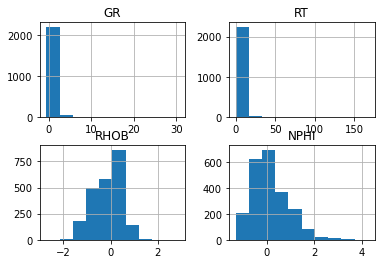

In [28]:
pd.DataFrame(X_train_scaled,index=X_train.index, columns=X_test.columns).hist()
plt.show()

In [29]:
X_train=pd.DataFrame(X_train_scaled,index=X_train.index, columns=X_test.columns)
X_test=pd.DataFrame(X_test_scaled,index=X_test.index, columns=X_test.columns)
X_test

,GR,RT,RHOB,NPHI
Depth,,,,
3281.0,0.350591,-0.449732,-1.118248,0.934572
4217.5,1.375298,-0.336194,0.618144,-0.424806
3640.0,-0.028625,0.359530,0.742023,-0.302674
4152.5,-0.246319,-0.576818,-0.709072,-0.007586
4088.0,-0.230364,-0.545448,-0.699896,0.005310
...,...,...,...,...
3699.5,2.998456,-0.275536,-1.017310,1.143941
3822.5,2.410683,0.155023,-0.470907,1.302484
3789.0,1.018952,-0.050579,0.012513,0.749478


In [33]:
iforest = IsolationForest(n_estimators=200, contamination=0.5/100)
iforest = iforest.fit(X_train) #Training the model

In [34]:
X_train_predict = iforest.predict(X_train) 
#X_train['Predict']=X_train_predict
X_train['Predict'] = X_train['Predict'].astype('category')
X_train

,GR,RT,RHOB,NPHI,Predict
Depth,,,,,
3958.0,1.255792,-0.160465,-0.045881,0.766167,1
3350.0,-0.085538,-0.555308,-1.136601,0.332259,1
3469.0,-0.553492,1.884563,0.608968,-0.936090,1
3885.5,1.832361,-0.145857,0.008342,1.140907,1
3867.0,-0.214751,31.833072,-1.184150,0.040963,1
...,...,...,...,...,...
3865.5,1.757852,-0.166015,0.009593,0.367153,1
3663.0,0.456133,0.042545,0.282795,-0.055376,1
3518.5,-0.375056,0.088924,0.220647,-0.364119,1


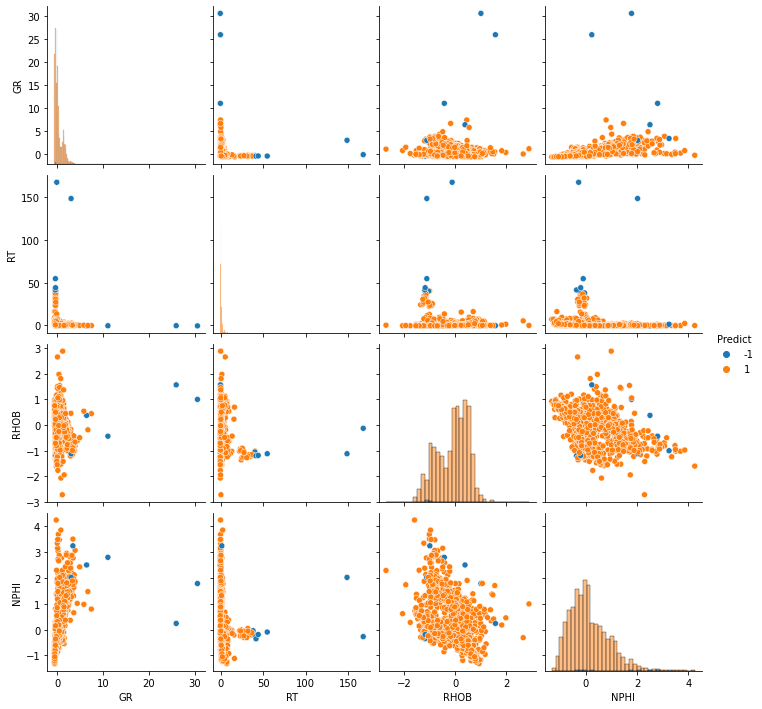

In [35]:
sns.pairplot(X_train,hue='Predict',diag_kind='hist')

In [39]:
y_train
X_train

,GR,RT,RHOB,NPHI,Predict
Depth,,,,,
3958.0,1.255792,-0.160465,-0.045881,0.766167,1
3350.0,-0.085538,-0.555308,-1.136601,0.332259,1
3469.0,-0.553492,1.884563,0.608968,-0.936090,1
3885.5,1.832361,-0.145857,0.008342,1.140907,1
3867.0,-0.214751,31.833072,-1.184150,0.040963,1
...,...,...,...,...,...
3865.5,1.757852,-0.166015,0.009593,0.367153,1
3663.0,0.456133,0.042545,0.282795,-0.055376,1
3518.5,-0.375056,0.088924,0.220647,-0.364119,1


In [40]:
X_train['y_train']=y_train
X_train = X_train[X_train['Predict'] == 1]

y_train=X_train['y_train']
X_train = X_train.drop(['Predict','y_train'], axis = 1)
X_train

,GR,RT,RHOB,NPHI
Depth,,,,
3958.0,1.255792,-0.160465,-0.045881,0.766167
3350.0,-0.085538,-0.555308,-1.136601,0.332259
3469.0,-0.553492,1.884563,0.608968,-0.936090
3885.5,1.832361,-0.145857,0.008342,1.140907
3867.0,-0.214751,31.833072,-1.184150,0.040963
...,...,...,...,...
3865.5,1.757852,-0.166015,0.009593,0.367153
3663.0,0.456133,0.042545,0.282795,-0.055376
3518.5,-0.375056,0.088924,0.220647,-0.364119


In [41]:
classifier = LogisticRegression(C=12) 
classifier.fit(X_train, y_train)

print(classifier.coef_) #a1 and a2
print(classifier.intercept_) # a0

[[-3.67313689  0.28571995  0.27931377 -4.28772263]
 [ 4.92754049 -0.55534219  1.50289156  2.85296314]
 [-2.78706877  0.35205708 -1.50503582 -0.16036646]
 [ 1.53266517 -0.08243485 -0.27716951  1.59512595]]
[ 1.75859533 -2.97128905  2.12101753 -0.90832381]


In [42]:
prediction = classifier.predict(X_test)

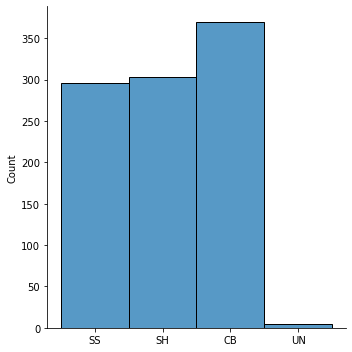

In [43]:
sns.displot(prediction)

In [44]:
#Compare against true labels (Accuracy)
print('Accuracy (generalization)',classifier.score(X_test,y_test)) #Accuracy (generalization)  
print('Accuracy (memorization)',classifier.score(X_train,y_train)) #Accuracy (memorization)

Accuracy (generalization) 0.8448098663926003
Accuracy (memorization) 0.849290780141844


In [46]:
#Comparing other metrics (f1_score)
print('F1_score (generalization)',f1_score(y_test,classifier.predict(X_test),average="weighted")) #Accuracy (generalization)  
print('F1_score (memorization)',f1_score(y_train,classifier.predict(X_train),average="weighted")) #Accuracy (memorization)

F1_score (generalization) 0.8332500848951337
F1_score (memorization) 0.8369541625535267


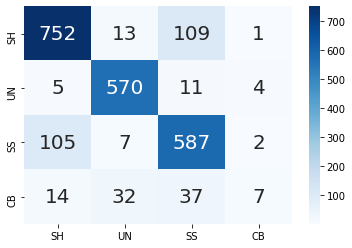

In [47]:
names = ['SH', 'UN', 'SS', 'CB']

cf_matrix = confusion_matrix(y_train, classifier.predict(X_train))

cf=sns.heatmap(cf_matrix, annot=True, annot_kws={"size": 20},cmap='Blues',fmt="d",xticklabels=names,yticklabels=names)

plt.show()